In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

events_data = pd.read_csv('event_data_train.csv')
submit = pd.read_csv('submissions_data_train.csv')

# Transform time into date
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data['day'] = events_data.date.dt.date
submit['date'] = pd.to_datetime(arg=submit['timestamp'], unit='s')
submit['day'] = submit['date'].dt.date

In [2]:
# Create users_scores
users_score = submit.pivot_table(index='user_id',
                                columns='submission_status',
                                values='step_id',
                                aggfunc='count',
                                fill_value=0)
users_score.head()

submission_status,correct,wrong
user_id,,
2,2,0
3,29,23
5,2,2
8,9,21
14,0,1


In [3]:
# Reset indexes
users_scores = submit.pivot_table(index='user_id',
                                columns='submission_status',
                                values='step_id',
                                aggfunc='count',
                                fill_value=0).reset_index()
users_score.head()

submission_status,correct,wrong
user_id,,
2,2,0
3,29,23
5,2,2
8,9,21
14,0,1


In [4]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [5]:
# Find last visit
visits = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_visit'})
visits.head()

,user_id,last_visit
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [6]:
# Whether user gone or not
red_line = 30 * 86400  # 30 days deadline
last_view = 1526772811

visits['is_gone_user'] = last_view - visits['last_visit'] > red_line
visits.head()

,user_id,last_visit,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [7]:
# Merge visits and users_score
users_data = visits.merge(
    right=users_scores,
    on='user_id',
    how='outer'
)

users_data.head()

,user_id,last_visit,is_gone_user,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN


In [8]:
# Fill Nan values
users_data.fillna(0)
users_data.head()

,user_id,last_visit,is_gone_user,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN


In [9]:
users_events_data = events_data.pivot_table(index='user_id',
                                           columns='action',
                                           values='step_id',
                                           aggfunc='count',
                                           fill_value=0).reset_index()

users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [10]:
# Merge users_data with users_events_data
users_data= users_data.merge(right=users_events_data,
                on='user_id',
                how='outer')

users_data.head()

,user_id,last_visit,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,NaN,NaN,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,NaN,NaN,1,1,0,1


In [11]:
# Unique days for each user
users_days = events_data.groupby('user_id').day.nunique()
users_days = users_days.to_frame().reset_index()
users_days.head()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


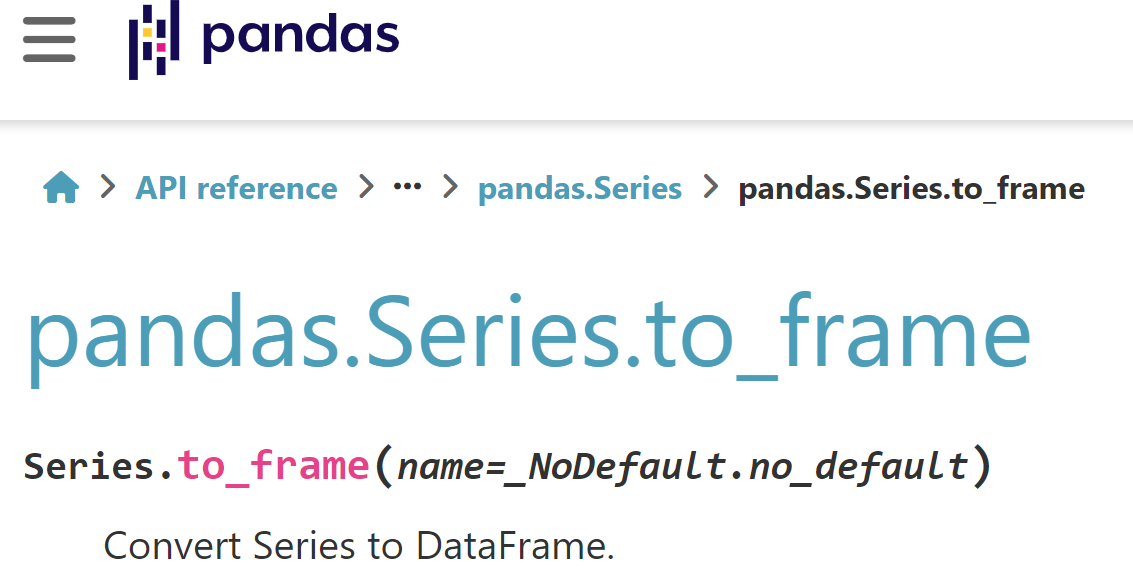

In [12]:
# Merge users_data and users_days
users_data = users_data.merge(right=users_days,
                             on='user_id',
                             how='outer')

users_data.head()

,user_id,last_visit,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,NaN,NaN,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,NaN,NaN,1,1,0,1,1


In [13]:
# Whether user passed particular course?
users_data['passed_course'] = users_data.passed > 170
users_data = users_data.fillna(0)
users_data.head()

,user_id,last_visit,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [14]:
# How many days are needed to solve course in median?
users_data[users_data.passed_course == True].day.median()

20.0

In [15]:
user_min_time = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'min'}) \
    .rename({'timestamp': 'min_timestamp'}, axis=1)

users_data = users_data.merge(user_min_time, on='user_id', how='outer')
users_data.head()

,user_id,last_visit,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [16]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [17]:
# Users events 3 days after begining of the course 
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)
events_data.shape

(3480703, 7)

[pandas.Series.map](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html)

In [18]:
# 3 days' seconds
time_threshold = 3 * 24 * 60 * 60
time_threshold

259200

# I Finished code here, continued watching without coding